In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from kmapper import KeplerMapper
from kmapper.cover import Cover
from sklearn.cluster import KMeans



In [4]:
data = pd.read_csv('Cancer_Data.csv')
data = pd.DataFrame(data)
data

FileNotFoundError: [Errno 2] No such file or directory: 'Cancer_Data.csv'

In [54]:
# Basic info
print(data.shape)
print(data.info())

# Quick statistics
print(data.describe())

# Check for missing values
print(data.isnull().sum())


(569, 33)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se    

C:\Users\HP\AppData\Local\Temp\ipykernel_38600\1758195493.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='diagnosis', data=data, palette='coolwarm')


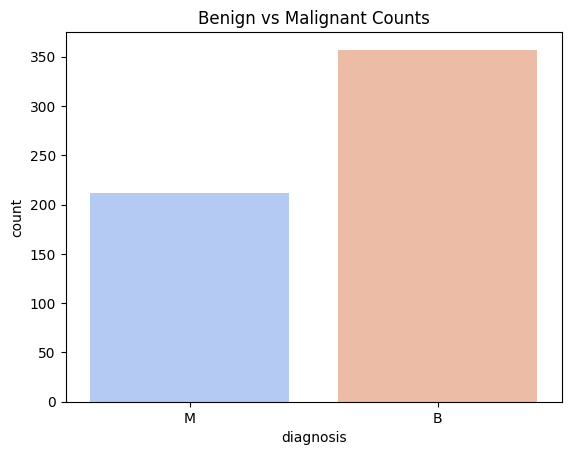

In [55]:
sns.countplot(x='diagnosis', data=data, palette='coolwarm')
plt.title("Benign vs Malignant Counts")
plt.show()

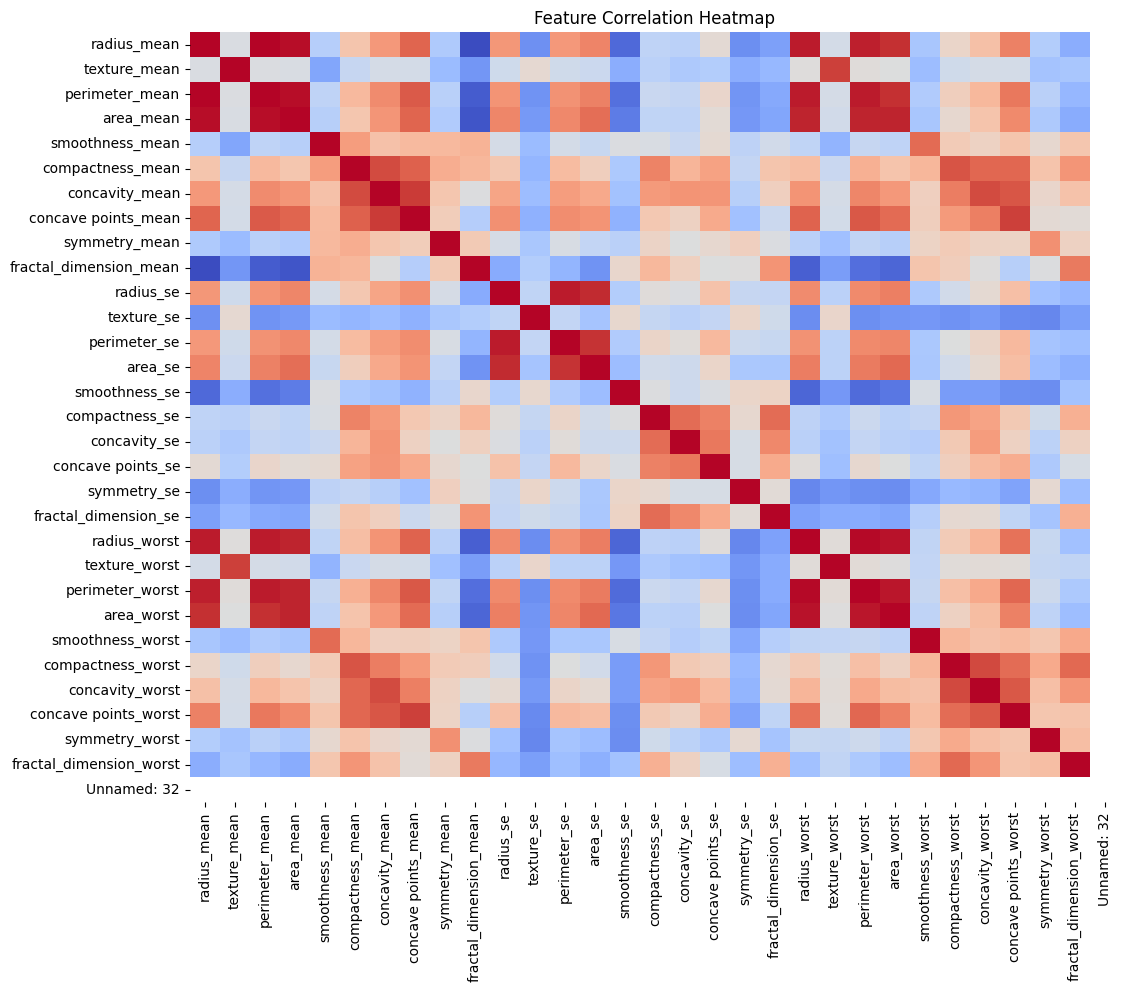

In [56]:
plt.figure(figsize=(12,10))
sns.heatmap(data.iloc[:,2:].corr(), cmap="coolwarm", cbar=False)
plt.title("Feature Correlation Heatmap")
plt.show()


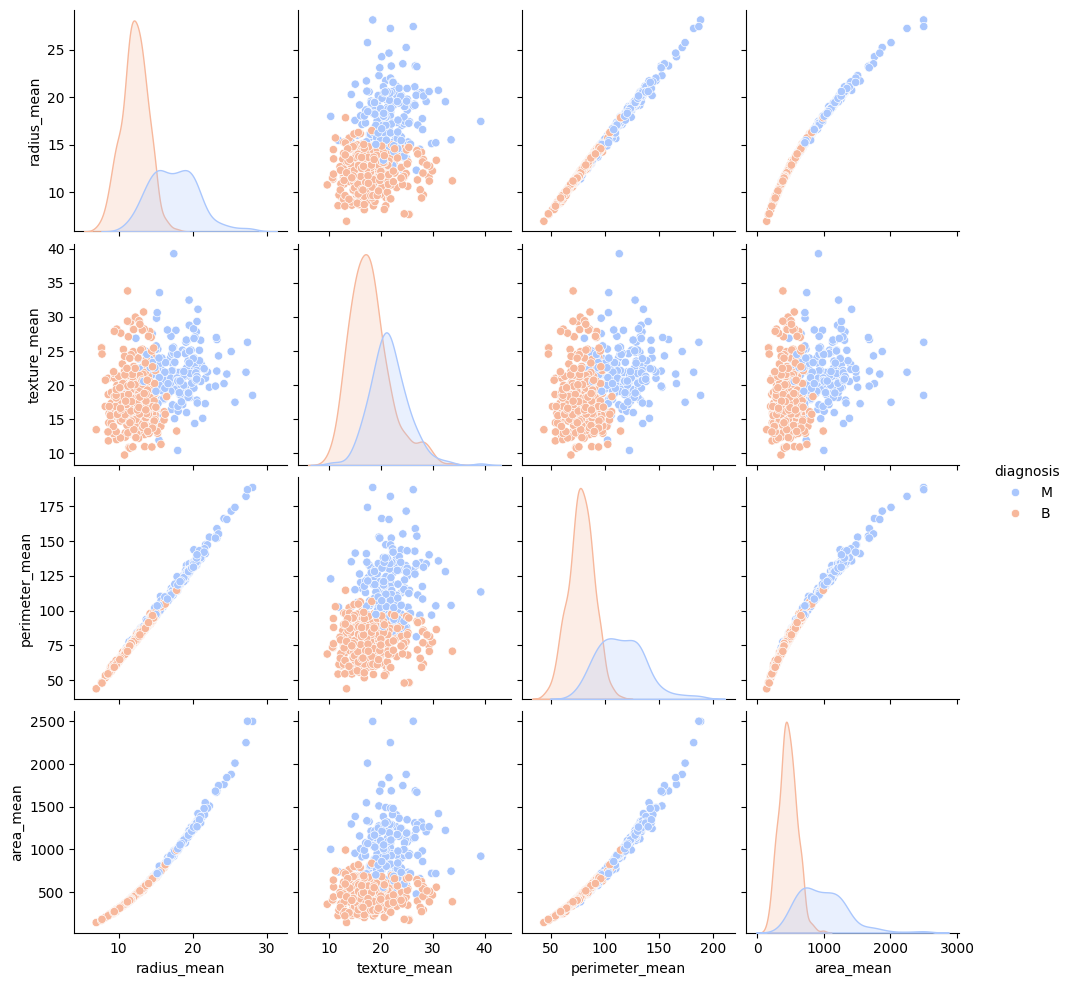

In [57]:
sns.pairplot(data[['diagnosis','radius_mean','texture_mean','perimeter_mean','area_mean']], 
             hue='diagnosis', palette='coolwarm')
plt.show()


Dropping all-NaN columns: ['Unnamed: 32']
PCA(2) explained variance ratios: [0.44272026 0.18971182]


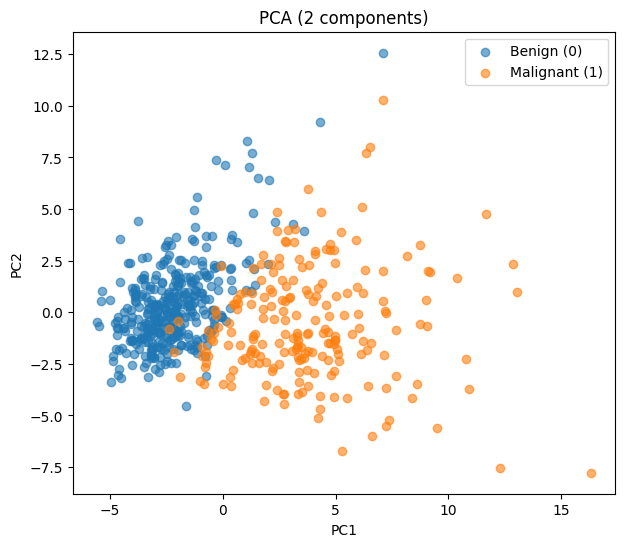

In [58]:

df = data.copy()

# 1) Drop non-feature columns
for col in ['id']:
    if col in df.columns:
        df = df.drop(columns=[col])

# 2) Encode target
y = None
if 'diagnosis' in df.columns:
    y = df['diagnosis'].map({'B':0, 'M':1})
    df = df.drop(columns=['diagnosis'])

# 3) Coerce to numeric and sanitize
for c in df.columns:
    df[c] = pd.to_numeric(df[c], errors='coerce')

df = df.replace([np.inf, -np.inf], np.nan)

# 4) Drop columns that are entirely NaN (e.g., "Unnamed: 32")
all_nan_cols = df.columns[df.isna().all()].tolist()
if all_nan_cols:
    print("Dropping all-NaN columns:", all_nan_cols)
    df = df.drop(columns=all_nan_cols)

# (Optional) also drop columns with near-zero non-missing counts, if any:
# few_obs_cols = [c for c in df.columns if df[c].notna().sum() < 2]
# if few_obs_cols:
#     print("Dropping columns with <2 observed values:", few_obs_cols)
#     df = df.drop(columns=few_obs_cols)

# 5) Impute
imp = SimpleImputer(strategy='median')
X_imputed = imp.fit_transform(df)
X_cols = df.columns.to_numpy()

# 6) Remove zero-variance columns
var_sel = VarianceThreshold(threshold=0.0)
X_nz = var_sel.fit_transform(X_imputed)
kept_mask = var_sel.get_support()
kept_cols = X_cols[kept_mask]
dropped_cols = X_cols[~kept_mask]
if dropped_cols.size:
    print("Dropped zero-variance columns:", dropped_cols.tolist())

# 7) Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_nz)

# 8) PCA
pca2 = PCA(n_components=2, random_state=0)
X_pca2 = pca2.fit_transform(X_scaled)

print("PCA(2) explained variance ratios:", pca2.explained_variance_ratio_)

# 9) Plots
if y is not None:
    y_np = y.to_numpy()
    plt.figure(figsize=(7,6))
    plt.scatter(X_pca2[y_np==0,0], X_pca2[y_np==0,1], alpha=0.6, label='Benign (0)')
    plt.scatter(X_pca2[y_np==1,0], X_pca2[y_np==1,1], alpha=0.6, label='Malignant (1)')
    plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title("PCA (2 components)")
    plt.legend(); plt.show()
else:
    plt.figure(figsize=(7,6))
    plt.scatter(X_pca2[:,0], X_pca2[:,1], alpha=0.6)
    plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title("PCA (2 components)")
    plt.show()

In [59]:

# We'll reuse df (cleaned features) and y (target) from before

# --- 1. Missingness
missing_pct = df.isna().mean() * 100

# --- 2. Variance
variance = df.var()

# --- 3. Correlation with target (if available)
corr_with_target = None
if y is not None:
    corr_with_target = df.corrwith(y)

# --- 4. Correlation matrix
corr_matrix = df.corr()

# --- 5. Collect into a feature report DataFrame
report = pd.DataFrame({
    "Missing (%)": missing_pct.round(2),
    "Variance": variance.round(4),
})

if corr_with_target is not None:
    report["Correlation with Diagnosis"] = corr_with_target.round(3)

# Sort by absolute correlation with diagnosis if available
if "Correlation with Diagnosis" in report.columns:
    report = report.reindex(report["Correlation with Diagnosis"].abs().sort_values(ascending=False).index)

print("\n--- Feature Report ---")
print(report)


--- Feature Report ---
                         Missing (%)     Variance  Correlation with Diagnosis
concave points_worst             0.0       0.0043                       0.794
perimeter_worst                  0.0    1129.1308                       0.783
concave points_mean              0.0       0.0015                       0.777
radius_worst                     0.0      23.3602                       0.776
perimeter_mean                   0.0     590.4405                       0.743
area_worst                       0.0  324167.3851                       0.734
radius_mean                      0.0      12.4189                       0.730
area_mean                        0.0  123843.5543                       0.709
concavity_mean                   0.0       0.0064                       0.696
concavity_worst                  0.0       0.0435                       0.660
compactness_mean                 0.0       0.0028                       0.597
compactness_worst                0.0    

In [60]:
def top_corr_pairs(corr_mat, n=10):
    corr_unstacked = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(bool)).unstack()
    corr_sorted = corr_unstacked.dropna().sort_values(ascending=False)
    return corr_sorted.head(n)

print("\n--- Top correlated feature pairs ---")
print(top_corr_pairs(corr_matrix, n=10))


--- Top correlated feature pairs ---
perimeter_mean   radius_mean        0.997855
perimeter_worst  radius_worst       0.993708
area_mean        radius_mean        0.987357
                 perimeter_mean     0.986507
area_worst       radius_worst       0.984015
                 perimeter_worst    0.977578
perimeter_se     radius_se          0.972794
perimeter_worst  perimeter_mean     0.970387
radius_worst     radius_mean        0.969539
                 perimeter_mean     0.969476
dtype: float64


In [61]:
# --- 1. Missingness
missing_pct = df.isna().mean() * 100

# --- 2. Variance
variance = df.var()

# --- 3. Correlation with target (if available)
corr_with_target = None
if y is not None:
    corr_with_target = df.corrwith(y)

# --- 4. Build report table
report = pd.DataFrame({
    "Missing (%)": missing_pct.round(2),
    "Variance": variance.round(4),
})

if corr_with_target is not None:
    report["Correlation with Diagnosis"] = corr_with_target.round(3)

# Sort by abs correlation if diagnosis exists
if "Correlation with Diagnosis" in report.columns:
    report = report.reindex(report["Correlation with Diagnosis"].abs().sort_values(ascending=False).index)

# --- 5. Style formatting (colors for interpretation)
def color_corr(val):
    if pd.isna(val): 
        return ''
    color = 'background-color: lightgreen' if abs(val) > 0.5 else ''
    return color

styled_report = (
    report.style
    .background_gradient(subset=["Variance"], cmap="Blues")
    .applymap(color_corr, subset=["Correlation with Diagnosis"])
    .format(precision=3)
)

styled_report

C:\Users\HP\AppData\Local\Temp\ipykernel_38600\4196345798.py:35: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(color_corr, subset=["Correlation with Diagnosis"])


,Missing (%),Variance,Correlation with Diagnosis
concave points_worst,0.000,0.004,0.794
perimeter_worst,0.000,1129.131,0.783
concave points_mean,0.000,0.002,0.777
radius_worst,0.000,23.360,0.776
perimeter_mean,0.000,590.441,0.743
area_worst,0.000,324167.385,0.734
radius_mean,0.000,12.419,0.730
area_mean,0.000,123843.554,0.709
concavity_mean,0.000,0.006,0.696
concavity_worst,0.000,0.043,0.660


In [62]:
# --- Prepare data (scaled) and lens
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.values)

pca = PCA(n_components=2, random_state=0)
lens = pca.fit_transform(X_scaled)

# --- Helper to build mapper with given params
def build_mapper_graph(X_scaled, lens, cover, clusterer, verbose=False):
    mapper = KeplerMapper(verbose=1 if verbose else 0)
    graph = mapper.map(
        lens,
        X_scaled,
        cover=cover,
        clusterer=clusterer,
        remove_duplicate_nodes=True,
    )
    n_nodes = len(graph["nodes"])
    n_edges = len(graph["links"])
    return mapper, graph, n_nodes, n_edges

# --- Search over a few sensible settings
covers = [
    ("c8_o40", Cover(n_cubes=8,  perc_overlap=0.40)),
    ("c10_o35", Cover(n_cubes=10, perc_overlap=0.35)),
    ("c12_o35", Cover(n_cubes=12, perc_overlap=0.35)),
]

clusterers = []
# DBSCAN variants (smaller -> tighter clusters; larger -> looser)
for eps in [0.3, 0.5, 0.7, 1.0]:
    clusterers.append((f"dbscan_eps{eps}", DBSCAN(eps=eps, min_samples=3)))
# KMeans fallback (guarantees nodes)
for k in [2, 3, 4]:
    clusterers.append((f"kmeans_k{k}", KMeans(n_clusters=k, random_state=0)))

results = []
best = None

for c_name, cov in covers:
    for cl_name, cl in clusterers:
        mapper, graph, n_nodes, n_edges = build_mapper_graph(X_scaled, lens, cov, cl)
        results.append((c_name, cl_name, n_nodes, n_edges, mapper, graph))
        print(f"[{c_name} | {cl_name}] -> nodes={n_nodes}, edges={n_edges}")
        # pick the first graph with a healthy number of nodes
        if best is None and 20 <= n_nodes <= 200:
            best = (c_name, cl_name, n_nodes, n_edges, mapper, graph)

# If nothing fell in the target range, just pick the one with the most nodes
if best is None and results:
    best = max(results, key=lambda t: t[2])

if best is None:
    raise RuntimeError("Mapper search produced no graphs. Check data scaling or try different lenses.")

c_name, cl_name, n_nodes, n_edges, best_mapper, best_graph = best
print(f"\nChosen config: cover={c_name}, clusterer={cl_name} -> nodes={n_nodes}, edges={n_edges}")

# --- Color & tooltips
color_vals = y.to_numpy() if y is not None else None
tooltip_cols = [c for c in df.columns if c.endswith('_mean')]
tooltip_cols = tooltip_cols[:5] if tooltip_cols else df.columns[:5]
custom_tooltips = df[tooltip_cols].round(3).astype(str).agg(' | '.join, axis=1).values

# --- Save HTML
html_path = f"mapper_breast_cancer_{c_name}_{cl_name}.html"
best_mapper.visualize(
    best_graph,
    path_html=html_path,
    title=f"Mapper — Breast Cancer ({c_name}, {cl_name})",
    color_values=color_vals,
    color_function_name="Diagnosis (1=Malignant)",
    custom_tooltips=custom_tooltips,
)
print(f"Saved: {html_path}")

[c8_o40 | dbscan_eps0.3] -> nodes=0, edges=0
[c8_o40 | dbscan_eps0.5] -> nodes=0, edges=0
[c8_o40 | dbscan_eps0.7] -> nodes=0, edges=0
[c8_o40 | dbscan_eps1.0] -> nodes=0, edges=0
[c8_o40 | kmeans_k2] -> nodes=76, edges=63
[c8_o40 | kmeans_k3] -> nodes=95, edges=75
[c8_o40 | kmeans_k4] -> nodes=113, edges=91
[c10_o35 | dbscan_eps0.3] -> nodes=0, edges=0
[c10_o35 | dbscan_eps0.5] -> nodes=0, edges=0
[c10_o35 | dbscan_eps0.7] -> nodes=0, edges=0
[c10_o35 | dbscan_eps1.0] -> nodes=0, edges=0
[c10_o35 | kmeans_k2] -> nodes=99, edges=77
[c10_o35 | kmeans_k3] -> nodes=119, edges=101
[c10_o35 | kmeans_k4] -> nodes=148, edges=119
[c12_o35 | dbscan_eps0.3] -> nodes=0, edges=0
[c12_o35 | dbscan_eps0.5] -> nodes=0, edges=0
[c12_o35 | dbscan_eps0.7] -> nodes=0, edges=0
[c12_o35 | dbscan_eps1.0] -> nodes=0, edges=0
[c12_o35 | kmeans_k2] -> nodes=124, edges=102
[c12_o35 | kmeans_k3] -> nodes=157, edges=125
[c12_o35 | kmeans_k4] -> nodes=181, edges=139

Chosen config: cover=c8_o40, clusterer=kmeans_k